<a href="https://colab.research.google.com/github/hyunjin2123/BA_ToDo/blob/main/%5B%EC%83%81%ED%92%88_%EB%B3%80%EC%88%98_%EC%B6%95%EC%86%8C%5D_%EC%95%84%EC%9D%B4%EC%8A%A4%ED%81%AC%EB%A6%BC_%ED%8C%90%EB%A7%A4%EB%9F%89_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 기상 영향에 따른 주요 판매 상품 카테고리 확인 및 판매량 예측

연구 목적

1) 기상 영향(평균기온,습도, 풍수, 강수량)별로 어떤 상품이 가장 잘 팔리는지 킬링 카테고리/상품 파악
2) 기상 영향에 따른 상품 또는 매장의 총판매량을 예측하여 상품 매입량 조절에 활용


연구 방법

1) 편의점의 일자별 판매량 데이터(12개 품목)
2) 일자별 기상청 데이터두 개의 데이터
3) 일자별 기상 지표와 상품별 판매량 데이터셋 생성
4) 변수별 상관관계 확인
5) 예측모델 적용
6) 기상 상황이 타겟 변수일 때의 상품 판매량 예측

연구 결론

더운날 아이스크림, 생수 상관관계가 가장 높음
상품과 매장을 축소해서 특이한 결합을 파악하기 어려웠음

In [1]:
# 나눔 폰트 설치 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,112 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [2]:
#런타임 다시 시작 후,
# matplotlib 폰트를 나눔 폰트로 지ㅣ정
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%matplotlib inline
import matplotlib as mpl               # 기본 설정
import matplotlib.pyplot as plt        # 그래프 관련
import matplotlib.font_manager as fm   # 폰트 관련
import seaborn as sns           # Seaborn 로딩하기
import os.path
import pandas as pd
import numpy as np
import lightgbm                         #LGBM 활용 - 기존 tree 기반 알고리즘과 달리 tree구조가 수직적으로 확장 *GBM이란 틀린부분에 가중치를 더하면서 진행하는 알고리즘
from tqdm import tqdm
import warnings

mpl.rcParams['axes.unicode_minus'] = False  ## 마이너스 부호가 깨지는 것 방지

#한글 사용하는 방법 !! 
#1. 먼저 나눔 폰트 설치
#2. 전체 폰트 갯수 중  나눔 폰트 갯수가 뜨는지 확인
#3. 런타임-런타임 다시 시작 후, 차트 plot 다시 실행

#!apt-get update -qq
#!apt-get install fonts-nanum* -qq              

#sys_font=fm.findSystemFonts()
#print(f"sys_font number: {len(sys_font)}")
#print(sys_font)                               

#nanum_font = [f for f in sys_font if 'Nanum' in f]
#print(f"nanum_font number: {len(nanum_font)}") 
#nanum_font

In [5]:
# 설치된 나눔글꼴중 원하는 폰트의 전체 경로 가져오기 
path = '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf'  
font_name = fm.FontProperties(fname=path, size=14).get_name()
print(font_name)

plt.rc('font', family=font_name)
print(fm.findSystemFonts(fontpaths=None, fontext='ttf'))

NanumSquare
['/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf', '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf', '/usr/share/fonts/truetype/libe

In [6]:
# 간단하게 그림을 그릴 수 있는 mglearn 라이브러리 사용 (!pip install mglearn 명령어로 설치)
!pip install mglearn
import mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 540 kB 4.2 MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582639 sha256=2a3496ffc8378ea8b33b480a9cddeaff499c7732316a98449ee18870dae2eb09
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


In [7]:
# 경고 끄기
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings(action='ignore')

## 데이터셋 만들기

In [8]:
#GS25 상품 판매 데이터 불러오기

from pandas.core.frame import DataFrame

import pandas as pd

# csv 데이터 가져오기
df_GS25 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/BigMining/최종과제/GS25.csv", encoding="cp949")

print(df_GS25.columns)
print(df_GS25.info())      #데이터정보파악 행, 열, 결측치 등
display(df_GS25.head(5))    #처음 5행 확인

Index(['korea_cvs.pvn_nm', 'korea_cvs.sale_dt', 'korea_cvs.gen_cd',
       'korea_cvs.age_cd', 'korea_cvs.category', 'korea_cvs.adj_qty',
       'korea_cvs.bor_nm'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2707786 entries, 0 to 2707785
Data columns (total 7 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   korea_cvs.pvn_nm    object
 1   korea_cvs.sale_dt   int64 
 2   korea_cvs.gen_cd    object
 3   korea_cvs.age_cd    object
 4   korea_cvs.category  object
 5   korea_cvs.adj_qty   int64 
 6   korea_cvs.bor_nm    object
dtypes: int64(2), object(5)
memory usage: 144.6+ MB
None


,korea_cvs.pvn_nm,korea_cvs.sale_dt,korea_cvs.gen_cd,korea_cvs.age_cd,korea_cvs.category,korea_cvs.adj_qty,korea_cvs.bor_nm
0,서울특별시,20160101,F,00~19,라면,7,종로구
1,서울특별시,20160101,F,20~39,과자,655,종로구
2,서울특별시,20160101,F,20~39,라면,282,종로구
3,서울특별시,20160101,F,20~39,마스크,35,종로구
4,서울특별시,20160101,F,20~39,맥주,183,종로구


In [9]:
df_GS25.columns=['광역시','ymd','성별','연령대','상품','수량','시군구']
df_GS25

,광역시,ymd,성별,연령대,상품,수량,시군구
0,서울특별시,20160101,F,00~19,라면,7,종로구
1,서울특별시,20160101,F,20~39,과자,655,종로구
2,서울특별시,20160101,F,20~39,라면,282,종로구
3,서울특별시,20160101,F,20~39,마스크,35,종로구
4,서울특별시,20160101,F,20~39,맥주,183,종로구
...,...,...,...,...,...,...,...
2707781,경기도,20181230,M,40~59,과자,7,여주시이천시
2707782,경기도,20181231,F,00~19,맥주,7,여주시이천시
2707783,경기도,20181231,F,20~39,생리대,7,여주시이천시
2707784,경기도,20181231,F,60~99,생리대,7,여주시이천시


In [10]:
df_GS25['시군구'].unique()

array(['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
       '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구',
       '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구', '동구', '미추홀구',
       '연수구', '남동구', '부평구', '계양구', '서구', '강화군', '옹진군', '수원시', '성남시',
       '의정부시', '안양시', '부천시', '광명시', '안산시', '고양시', '과천시', '구리시', '남양주시',
       '시흥시', '군포시', '의왕시', '하남시', '용인시', '파주시', '김포시', '화성시', '광주시',
       '오산시안성시평택시', '양주시', '동두천시', '연천군포천군', '가평군양평군', '여주시이천시'],
      dtype=object)

In [18]:
#강남구 자료만 선택
df_GS25_temp = df_GS25[df_GS25['시군구'] == '강남구'] # 시군구 열이 '종로구'인 행들만 추출
df_GS25_temp

,광역시,ymd,성별,연령대,상품,수량,시군구
369212,서울특별시,20160101,F,00~19,과자,21,강남구
369213,서울특별시,20160101,F,00~19,라면,49,강남구
369214,서울특별시,20160101,F,00~19,맥주,21,강남구
369215,서울특별시,20160101,F,00~19,생리대,14,강남구
369216,서울특별시,20160101,F,00~19,생수,7,강남구
...,...,...,...,...,...,...,...
2593045,서울특별시,20181231,F,60~99,아이스크림,7,강남구
2593046,서울특별시,20181231,M,00~19,라면,7,강남구
2593047,서울특별시,20181231,M,00~19,생수,7,강남구
2593048,서울특별시,20181231,M,00~19,아이스크림,7,강남구


In [21]:
df_GS25_temp = df_GS25_temp.drop(['광역시','성별','연령대','시군구'], axis=1)
df_GS25_temp

,ymd,상품,수량
369212,20160101,과자,21
369213,20160101,라면,49
369214,20160101,맥주,21
369215,20160101,생리대,14
369216,20160101,생수,7
...,...,...,...
2593045,20181231,아이스크림,7
2593046,20181231,라면,7
2593047,20181231,생수,7
2593048,20181231,아이스크림,7


In [22]:
df_GS25_temp.groupby(['ymd','상품']).수량.sum()

ymd       상품   
20160101  과자       4370
          라면       1783
          마스크         7
          맥주       1028
          면도기        49
                   ... 
20181231  생수        697
          숙취해소제     204
          스타킹       169
          아이스크림     712
          탄산음료      295
Name: 수량, Length: 12445, dtype: int64

In [23]:
product = pd.DataFrame(df_GS25_temp.groupby(['ymd','상품']).수량.sum()).reset_index()
df_GS25_final = product.pivot('ymd','상품','수량').fillna(0)
df_GS25_final

상품,과자,라면,마스크,맥주,면도기,생리대,생수,숙취해소제,스타킹,아이스크림,우산,탄산음료
ymd,,,,,,,,,,,,
20160101,4370.0,1783.0,7.0,1028.0,49.0,309.0,662.0,190.0,70.0,1607.0,0.0,464.0
20160102,3933.0,1930.0,28.0,1262.0,56.0,246.0,683.0,148.0,77.0,1410.0,0.0,303.0
20160103,3664.0,1748.0,21.0,1107.0,28.0,140.0,592.0,219.0,77.0,1952.0,7.0,443.0
20160104,3799.0,2352.0,49.0,810.0,49.0,274.0,973.0,225.0,120.0,902.0,0.0,494.0
20160105,3877.0,3044.0,35.0,691.0,42.0,274.0,726.0,289.0,198.0,1367.0,0.0,507.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20181227,2530.0,2543.0,154.0,1100.0,14.0,169.0,719.0,464.0,49.0,796.0,0.0,260.0
20181228,3467.0,1796.0,162.0,902.0,14.0,169.0,472.0,486.0,127.0,564.0,0.0,373.0
20181229,2847.0,1860.0,70.0,796.0,21.0,126.0,381.0,225.0,77.0,486.0,0.0,247.0


In [26]:
df_GS25_final = df_GS25_final.drop(['과자', '라면', '마스크', '맥주', '면도기', '생리대', '생수', '숙취해소제', '스타킹', '우산', '탄산음료'], axis=1)
df_GS25_final

상품,아이스크림
ymd,
20160101,1607.0
20160102,1410.0
20160103,1952.0
20160104,902.0
20160105,1367.0
...,...
20181227,796.0
20181228,564.0
20181229,486.0


In [27]:
print(df_GS25_final.describe())

상품          아이스크림
count  1096.00000
mean   2298.40146
std    1518.61985
min     429.00000
25%    1070.75000
50%    1815.00000
75%    3221.00000
max    7808.00000


In [28]:
#기상청 기상 데이터 불러오기

# csv 데이터 가져오기
df_wether = pd.read_csv("/content/drive/My Drive/Colab Notebooks/BigMining/최종과제/기상데이터.csv", encoding="cp949")

print(df_wether.columns)
print(df_wether.info())      #데이터정보파악 행, 열, 결측치 등
display(df_wether.head(5))      #처음 5행 확인

Index(['bigcon_weather.tm', 'bigcon_weather.stn_id', 'bigcon_weather.pvn_nm',
       'bigcon_weather.bor_nm', 'bigcon_weather.max_ta',
       'bigcon_weather.max_ws', 'bigcon_weather.min_ta',
       'bigcon_weather.avg_ta', 'bigcon_weather.avg_rhm',
       'bigcon_weather.avg_ws', 'bigcon_weather.sum_rn'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59113 entries, 0 to 59112
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bigcon_weather.tm       59113 non-null  int64  
 1   bigcon_weather.stn_id   59113 non-null  int64  
 2   bigcon_weather.pvn_nm   59113 non-null  object 
 3   bigcon_weather.bor_nm   59113 non-null  object 
 4   bigcon_weather.max_ta   58826 non-null  float64
 5   bigcon_weather.max_ws   58778 non-null  float64
 6   bigcon_weather.min_ta   58826 non-null  float64
 7   bigcon_weather.avg_ta   58814 non-null  float64
 8   bigcon_weather.avg_rhm  43

,bigcon_weather.tm,bigcon_weather.stn_id,bigcon_weather.pvn_nm,bigcon_weather.bor_nm,bigcon_weather.max_ta,bigcon_weather.max_ws,bigcon_weather.min_ta,bigcon_weather.avg_ta,bigcon_weather.avg_rhm,bigcon_weather.avg_ws,bigcon_weather.sum_rn
0,20160101,98,경기도,동두천시,6.5,3.8,-6.4,-0.2,74.0,0.9,0.0
1,20160102,98,경기도,동두천시,10.1,3.2,1.9,5.4,70.0,1.3,0.0
2,20160103,98,경기도,동두천시,9.0,2.4,2.1,4.7,82.0,0.7,0.0
3,20160104,98,경기도,동두천시,8.0,5.3,-3.0,1.9,55.0,2.2,0.0
4,20160105,98,경기도,동두천시,3.1,5.6,-6.4,-2.8,36.0,1.8,0.0


In [29]:
df_wether_temp = df_wether.drop(columns = ['bigcon_weather.stn_id','bigcon_weather.max_ta','bigcon_weather.max_ws','bigcon_weather.min_ta'])
df_wether_temp.columns=['ymd','광역시','시군구','평균기온','습도','평균풍속','강수량']
df_wether_temp.head()

,ymd,광역시,시군구,평균기온,습도,평균풍속,강수량
0,20160101,경기도,동두천시,-0.2,74.0,0.9,0.0
1,20160102,경기도,동두천시,5.4,70.0,1.3,0.0
2,20160103,경기도,동두천시,4.7,82.0,0.7,0.0
3,20160104,경기도,동두천시,1.9,55.0,2.2,0.0
4,20160105,경기도,동두천시,-2.8,36.0,1.8,0.0


In [30]:
#기상데이터도 종로구 자료만 선택
df_wether_final = df_wether_temp[df_wether_temp['시군구'] == '강남구'] # 시군구 열이 '강남구'인 행들만 추출
df_wether_final.head(10)

,ymd,광역시,시군구,평균기온,습도,평균풍속,강수량
7672,20160101,서울특별시,강남구,2.1,73.0,1.2,0.0
7673,20160102,서울특별시,강남구,7.1,73.0,1.1,0.0
7674,20160103,서울특별시,강남구,7.7,80.0,0.9,0.0
7675,20160104,서울특별시,강남구,3.4,51.0,2.4,0.0
7676,20160105,서울특별시,강남구,-1.0,36.0,1.7,0.0
7677,20160106,서울특별시,강남구,-0.2,51.0,1.6,0.0
7678,20160107,서울특별시,강남구,-1.7,46.0,2.0,0.0
7679,20160108,서울특별시,강남구,-1.3,47.0,1.7,0.0
7680,20160109,서울특별시,강남구,-0.3,53.0,1.8,0.0
7681,20160110,서울특별시,강남구,1.8,40.0,1.7,0.0


In [31]:
df_wether_final = df_wether_final.drop(['광역시','시군구',], axis=1)
df_wether_final.tail()

,ymd,평균기온,습도,평균풍속,강수량
8762,20181227,-9.2,28.0,2.8,0.0
8763,20181228,-9.5,34.0,2.0,0.0
8764,20181229,-6.6,29.0,2.3,0.0
8765,20181230,-5.9,37.0,1.3,0.0
8766,20181231,-4.3,42.0,1.4,0.0


In [32]:
df_wether_final = df_wether_final.fillna(0)
df_wether_final.isnull().sum()

ymd     0
평균기온    0
습도      0
평균풍속    0
강수량     0
dtype: int64

In [50]:
#gs 데이터와 기상 데이터 결합하기

df = pd.merge( df_wether_final, df_GS25_final,on="ymd", how="left")
df.info()  #1096개 데이터로 3년 모두 포함되어 있음을 확인
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 0 to 1094
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ymd     1095 non-null   int64  
 1   평균기온    1095 non-null   float64
 2   습도      1095 non-null   float64
 3   평균풍속    1095 non-null   float64
 4   강수량     1095 non-null   float64
 5   아이스크림   1095 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 59.9 KB


,ymd,평균기온,습도,평균풍속,강수량,아이스크림
0,20160101,2.1,73.0,1.2,0.0,1607.0
1,20160102,7.1,73.0,1.1,0.0,1410.0
2,20160103,7.7,80.0,0.9,0.0,1952.0
3,20160104,3.4,51.0,2.4,0.0,902.0
4,20160105,-1.0,36.0,1.7,0.0,1367.0


In [51]:
from datetime import datetime
df['ymd']= df['ymd'].astype('str')
df['ymd'].apply(lambda _ : datetime.strptime(_,'%Y%m%d'))

0      2016-01-01
1      2016-01-02
2      2016-01-03
3      2016-01-04
4      2016-01-05
          ...    
1090   2018-12-27
1091   2018-12-28
1092   2018-12-29
1093   2018-12-30
1094   2018-12-31
Name: ymd, Length: 1095, dtype: datetime64[ns]

In [52]:
df.set_index('ymd', inplace=True)
df

,평균기온,습도,평균풍속,강수량,아이스크림
ymd,,,,,
20160101,2.1,73.0,1.2,0.0,1607.0
20160102,7.1,73.0,1.1,0.0,1410.0
20160103,7.7,80.0,0.9,0.0,1952.0
20160104,3.4,51.0,2.4,0.0,902.0
20160105,-1.0,36.0,1.7,0.0,1367.0
...,...,...,...,...,...
20181227,-9.2,28.0,2.8,0.0,796.0
20181228,-9.5,34.0,2.0,0.0,564.0
20181229,-6.6,29.0,2.3,0.0,486.0


In [36]:
print(df.columns) #

Index(['평균기온', '습도', '평균풍속', '강수량', '아이스크림'], dtype='object')


##데이터 탐색


In [53]:
# 기술통계 확인하기
print(df.describe())

              평균기온           습도         평균풍속          강수량        아이스크림
count  1095.000000  1095.000000  1095.000000  1095.000000  1095.000000
mean     13.991050    58.327854     1.638904     3.254795  2299.155251
std      10.898953    15.320145     0.495927    12.691150  1519.108613
min     -13.800000     0.000000     0.000000     0.000000   429.000000
25%       4.450000    46.000000     1.300000     0.000000  1070.500000
50%      15.400000    58.000000     1.600000     0.000000  1818.000000
75%      23.200000    68.000000     1.900000     0.000000  3221.000000
max      34.300000    99.000000     4.400000   129.000000  7808.000000


In [54]:
# 상관계수 확인하기 1 - 매트릭스 형태
corr_df = df.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
corr_df

,평균기온,습도,평균풍속,강수량,아이스크림
평균기온,1.00,0.43,-0.22,0.14,0.80
습도,0.43,1.00,-0.23,0.47,0.24
평균풍속,-0.22,-0.23,1.00,-0.05,-0.07
강수량,0.14,0.47,-0.05,1.00,0.01
아이스크림,0.80,0.24,-0.07,0.01,1.00


In [55]:
# 상관계수 확인하기 2 - 시리즈 형태
s = corr_df.unstack()
s

평균기온   평균기온     1.00
       습도       0.43
       평균풍속    -0.22
       강수량      0.14
       아이스크림    0.80
습도     평균기온     0.43
       습도       1.00
       평균풍속    -0.23
       강수량      0.47
       아이스크림    0.24
평균풍속   평균기온    -0.22
       습도      -0.23
       평균풍속     1.00
       강수량     -0.05
       아이스크림   -0.07
강수량    평균기온     0.14
       습도       0.47
       평균풍속    -0.05
       강수량      1.00
       아이스크림    0.01
아이스크림  평균기온     0.80
       습도       0.24
       평균풍속    -0.07
       강수량      0.01
       아이스크림    1.00
dtype: float64

In [56]:
# 상관계수 확인하기 3 - DataFrame의 style프로퍼티 형태
corr_df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr'])
corr_df.style.background_gradient(cmap='viridis')    # 0.4 이상을 유의미하다고 봄

,,corr
평균기온,아이스크림,0.800000
아이스크림,평균기온,0.800000
습도,강수량,0.470000
강수량,습도,0.470000
평균기온,습도,0.430000
습도,평균기온,0.430000
아이스크림,습도,0.240000
습도,아이스크림,0.240000
강수량,평균기온,0.140000
평균기온,강수량,0.140000


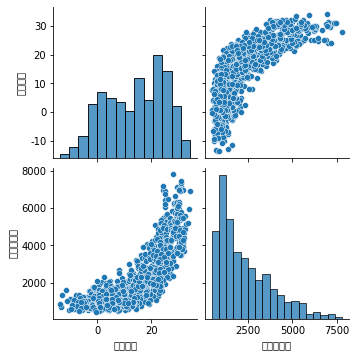

In [57]:
# scatter
cols = ["평균기온","아이스크림"]
sns.pairplot(df[cols])
plt.show()

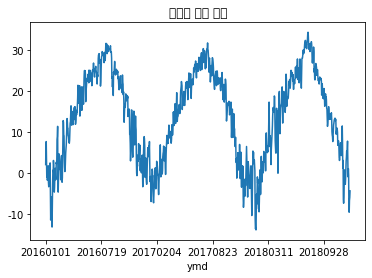

In [58]:
df['평균기온'].plot(title = '일자별 평균 기온')

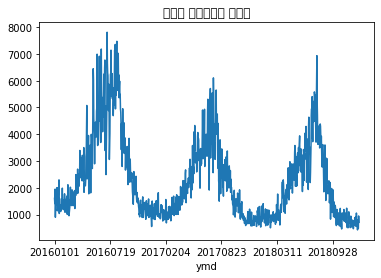

In [59]:
df['아이스크림'].plot(title = '일자별 아이스크림 판매량')

#회귀분석

In [60]:
# Python ≥3.5 이상을 권장
import sys
print("Python version: {}".format(sys.version))

# Scikit-Learn ≥0.20 이상을 권장
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))

Python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
scikit-learn version: 1.0.2


## 데이터 전처리
 - 학습/테스트데이터 분할
 - 독립변수 표준화 수행


In [61]:
exp_df = df
display(exp_df.head(3))
exp_df.describe()  #변수 scale확인
print(exp_df.isnull().sum())  #결측치 확인

,평균기온,습도,평균풍속,강수량,아이스크림
ymd,,,,,
20160101,2.1,73.0,1.2,0.0,1607.0
20160102,7.1,73.0,1.1,0.0,1410.0
20160103,7.7,80.0,0.9,0.0,1952.0


평균기온     0
습도       0
평균풍속     0
강수량      0
아이스크림    0
dtype: int64


In [62]:
y = exp_df["아이스크림"]
X = exp_df.iloc[:,0:-1]
display(X.head())

,평균기온,습도,평균풍속,강수량
ymd,,,,
20160101,2.1,73.0,1.2,0.0
20160102,7.1,73.0,1.1,0.0
20160103,7.7,80.0,0.9,0.0
20160104,3.4,51.0,2.4,0.0
20160105,-1.0,36.0,1.7,0.0


In [63]:
# 학습 / 테스트데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# 독립변수 표준화 
from sklearn.preprocessing import StandardScaler

s_scaler = StandardScaler()
s_scaler.fit_transform(X_train)
s_scaler.transform(X_test)

In [65]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_predict = lr_model.predict(X_test)

In [66]:
train_performance = lr_model.score(X_train, y_train)
test_performance = lr_model.score(X_test, y_test)
print("아이스크림 판매량 예측결과: \n", y_predict[0:10])
print("훈련 성능: {}   테스트 성능: {}".format(train_performance, test_performance))
print(X_train.columns)

np.set_printoptions(suppress=True, precision =2) #넘파이 결과가 지수형태로 나와서 보기 안좋아서 지수 제한
print("회귀식: {}  절편: {}".format(lr_model.coef_, lr_model.intercept_))

#독립변수가 종속변수의 변동을 72.7% 설명
#그러나, 머신러닝에서는 MAE, RMSE를 더 중요한 성능으로 고려함

아이스크림 판매량 예측결과: 
 [3728.35285037 3592.08354108 2370.42943706 2496.6526136  3306.53330282
 2055.20364199 2497.20172101 3894.35053153  888.0304623   409.96170713]
훈련 성능: 0.6546267758827768   테스트 성능: 0.6674904028640738
Index(['평균기온', '습도', '평균풍속', '강수량'], dtype='object')
회귀식: [120.05  -5.26 313.95  -9.61]  절편: 441.56452131518245


In [67]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#mean_absolute_error(실제, 예측)
print("MAE:", mean_absolute_error(y_test, y_predict ))
print("RMSE:", mean_squared_error(y_test, y_predict))

#MAE기준으로 해석하면, 회귀식이 평균적으로 예측한 아이스크림판매량은 실제값과 약 539개 정도 오차가 있음.

MAE: 676.1850217905873
RMSE: 753532.4221682443


## Feature Engineering

In [68]:
from sklearn.preprocessing import PolynomialFeatures

poly =PolynomialFeatures(degree = 2, include_bias = False)  #2제곱까지, include_bias = False 절편은 포함 안함. 회귀식에서 자동으로 포함하니 불필요
poly.fit(X_train)
train_poly = poly.transform(X_train)
test_poly = poly.transform(X_test)

print(train_poly.shape)
print(test_poly.shape)
poly.get_feature_names()

(876, 14)
(219, 14)


['x0',
 'x1',
 'x2',
 'x3',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x2^2',
 'x2 x3',
 'x3^2']

In [69]:
lr_model2 = LinearRegression()
lr_model2.fit(train_poly, y_train)
y_predict = lr_model2.predict(test_poly)
train_performance2 = lr_model2.score(train_poly, y_train)
test_performance2 = lr_model2.score(test_poly, y_test)
print("훈련 성능: {}   테스트 성능: {}".format(train_performance2, test_performance2))
print("MAE:", mean_absolute_error(y_test, y_predict ))
print("RMSE:", mean_squared_error(y_test, y_predict))

#R2가 향상되었으며, 오차율이 줄어듦
#실제 아이스크림 판매량과 예측 아이스크림 판매량이 평균 438개 정도 차이남

훈련 성능: 0.7750719546504133   테스트 성능: 0.7435990052679762
MAE: 560.1571287510357
RMSE: 581055.2966619744


In [ ]:
# 학습/테스트 : 층화 추출
# 회귀식 변수 선택 *


# 구체적인 모형의 도출
import numpy as np
np.set_printoptions(suppress=True, precision =2) #넘파이 결과가 지수형태로 나와서 보기 안좋아서 지수 제한

print("회귀계수: {}  절편:{}".format(lr_model2.coef_, lr_model2.intercept_))

##회귀분석 - sklearn 이용 - Ridge & Lasso 회귀분석

In [71]:
from sklearn.linear_model import Ridge  #Lasso는 Ridge를 Lasso로만 변경

Ridge = Ridge(alpha = 0.3)
Ridge.fit(train_poly, y_train)
y_predict = Ridge.predict(test_poly)
train_performance3 = Ridge.score(train_poly, y_train)
test_performance3 = Ridge.score(test_poly, y_test)
print("훈련 성능: {}   테스트 성능: {}".format(train_performance3, test_performance3))
print("MAE:", mean_absolute_error(y_test, y_predict ))
print("RMSE:", mean_squared_error(y_test, y_predict))

print("회귀계수: {}  절편:{}".format(Ridge.coef_, Ridge.intercept_))

# 학습/테스트 데이터 변동 없음
#MAE도 동일

훈련 성능: 0.7750719185823562   테스트 성능: 0.7435907862878989
MAE: 560.1395430563828
RMSE: 581073.922494187
회귀계수: [ -17.6   -25.41   41.71   39.8     5.47   -0.66   20.91   -0.3     0.16
    7.84   -0.39 -123.05   -9.57    0.11]  절편:1440.0626668037792


In [72]:
from sklearn.linear_model import Lasso  #Lasso는 Ridge를 Lasso로만 변경

Lasso = Lasso(alpha = 0.3)
Lasso.fit(train_poly, y_train)
y_predict = Lasso.predict(test_poly)
train_performance3 = Lasso.score(train_poly, y_train)
test_performance3 = Lasso.score(test_poly, y_test)
print("훈련 성능: {}   테스트 성능: {}".format(train_performance3, test_performance3))
print("MAE:", mean_absolute_error(y_test, y_predict ))
print("RMSE:", mean_squared_error(y_test, y_predict))

print("회귀계수: {}  절편:{}".format(Lasso.coef_, Lasso.intercept_))

# 학습/테스트 데이터 변동 없음
#MAE도 동일

훈련 성능: 0.7750666572775925   테스트 성능: 0.7435143429687909
MAE: 559.9431487116461
RMSE: 581247.1581538557
회귀계수: [ -17.66  -25.42    0.     38.92    5.48   -0.66   20.92   -0.3     0.16
    8.09   -0.38 -115.76   -9.63    0.11]  절편:1476.5376959322402
